# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import xgboost as xgb

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report

# Import data and make same changes as EDA markdownn

In [3]:
df = pd.read_csv("Airline Passenger Satisfaction.csv").set_index('id').drop(columns=['Unnamed: 0'])

df['satisfaction_3'] = df['satisfaction score'].apply(lambda x: 'satisfied' if x > 8 else 'neutral' if 6 < x <= 8 else 'dissatisfied')

df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,satisfaction score,satisfaction_3
id,,,,,,,,,,,,,,,,,,,,,
70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,3,4,4,5,5,25,18,neutral or dissatisfied,7,neutral
5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,5,3,1,4,1,1,6,neutral or dissatisfied,3,dissatisfied
110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,3,4,4,4,5,0,0,satisfied,9,satisfied
24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,5,3,1,4,2,11,9,neutral or dissatisfied,6,dissatisfied
119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,4,4,3,3,3,0,0,satisfied,10,satisfied


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 70172 to 34799
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Gender                             129880 non-null  object
 1   Customer Type                      129880 non-null  object
 2   Age                                129880 non-null  int64 
 3   Type of Travel                     129880 non-null  object
 4   Class                              129880 non-null  object
 5   Flight Distance                    129880 non-null  int64 
 6   Inflight wifi service              129880 non-null  int64 
 7   Departure/Arrival time convenient  129880 non-null  int64 
 8   Ease of Online booking             129880 non-null  int64 
 9   Gate location                      129880 non-null  int64 
 10  Food and drink                     129880 non-null  int64 
 11  Online boarding                    129880 non-nul

In [5]:
df['satisfaction'].value_counts()

neutral or dissatisfied    73452
satisfied                  56428
Name: satisfaction, dtype: int64

In [6]:
df['satisfaction_3'].value_counts()

dissatisfied    59246
satisfied       56428
neutral         14206
Name: satisfaction_3, dtype: int64

In [7]:
df['satisfaction score'].value_counts()

9     28380
10    28048
5     22260
6     22053
3      7499
4      7315
8      7161
7      7045
0        44
2        43
1        32
Name: satisfaction score, dtype: int64

# Data Preparation

In [8]:
# Step 1: Prepare data
X = df.drop(['satisfaction', 'satisfaction score', 'satisfaction_3'], axis=1)
y = df['satisfaction_3']

# Encode target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Step 2: Handle categorical columns
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

# Use OneHotEncoder to transform categorical features into numeric representations
# Set sparse=False to return a dense array instead of a sparse matrix
ct = ColumnTransformer([('encoder', OneHotEncoder(), categorical_columns)], remainder='passthrough')
X_encoded = ct.fit_transform(X)

# Step 3: Perform k-fold cross-validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)

# Initialize a list to store accuracy scores for each fold
accuracy_per_fold = []

for train_index, val_index in kf.split(X_encoded):
    X_train_fold, X_val_fold = X_encoded[train_index], X_encoded[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]
    
    # Create and train the XGBoost classifier for this fold
    model_fold = xgb.XGBClassifier(objective='multi:softmax', num_class=3)  # Multi-class classification with 3 classes
    model_fold.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set for this fold
    y_pred_fold = model_fold.predict(X_val_fold)
    
    # Calculate accuracy for this fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    accuracy_per_fold.append(accuracy_fold)

# Calculate the average accuracy across all folds
average_accuracy = sum(accuracy_per_fold) / k_folds

print("Average Accuracy with k-fold cross-validation:", average_accuracy)

# Step 4: Train the final model on the entire dataset
model_final = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
model_final.fit(X_encoded, y_encoded)

# Step 5: Make predictions on the entire dataset
y_pred_final = model_final.predict(X_encoded)

# Step 6: Evaluate the model on the entire dataset
accuracy_final = accuracy_score(y_encoded, y_pred_final)
print("Accuracy on the entire dataset:", accuracy_final)

# Print the classification report to see precision, recall, and F1-score for each class
print(classification_report(y_encoded, y_pred_final))

Average Accuracy with k-fold cross-validation: 0.9556513704958423
Accuracy on the entire dataset: 0.9724129966122574
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     59246
           1       0.94      0.95      0.94     14206
           2       0.98      0.96      0.97     56428

    accuracy                           0.97    129880
   macro avg       0.96      0.97      0.97    129880
weighted avg       0.97      0.97      0.97    129880



In [9]:
# Save model
model_final.save_model('xgb_model_untuned.json')

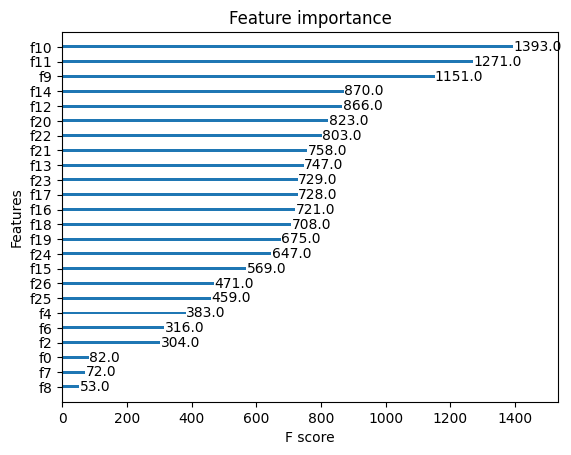

In [9]:
# Plot important features in the model
xgb.plot_importance(model_final, grid=False, importance_type='weight')
plt.show()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

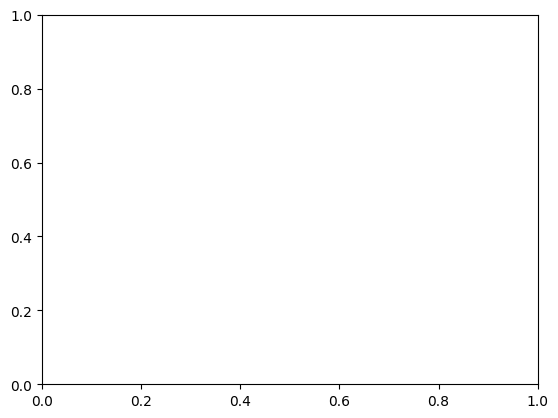

In [10]:
# Plot of decision tree
xgb.plot_tree(model_final)
plt.show()

# Hyperparameter Tuning

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1)

# Step 5: Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3,4,5,6,7,8,9],
    'n_estimators': [50,100,150],
    'learning_rate': [0.01,0.1,0.3]
}

# Step 6: Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

# Step 7: Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=model_final, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best hyperparameters found:")
print(grid_search.best_params_)
print("Best accuracy found during hyperparameter tuning:", grid_search.best_score_)

# Step 8: Get the best model from the GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Step 9: Make predictions on the test set using the best model
y_pred_test = best_xgb_model.predict(X_test)

# Step 10: Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on the test set with the best model:", accuracy_test)

# Print the classification report to see precision, recall, and F1-score for each class
print(classification_report(y_test, y_pred_test))

KeyboardInterrupt: 

In [1]:
best_xgb_model.save_model('xbg_model_tuned.json')

NameError: name 'best_xgb_model' is not defined

In [ ]:
# Plot important features in the model
xgb.plot_importance(best_xgb_model, grid=False, importance_type='weight')
plt.show()

In [ ]:
# Plot of decision tree
xgb.plot_tree(best_xgb_model)
plt.show()